### **Load libraries - Julia 1.7**

In [14]:
using Pkg
Pkg.activate(@__DIR__)

  Activating project at `~/Documents/Github/rnc2_project`


In [15]:
using Graphs
using GraphPlot
using DataFrames, Random, Distributions, Chain
using Plots
using ProgressBars

### **Display example graph and distribution function**

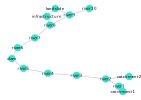

In [16]:
# Display graph
g = Graph(15) # graph with 3 vertices

# make a "river" with dam as center point
for i in 1:10
    add_edge!(g, i, i+1)
end

# add labels
nodelabel = ["river1", "river2", "river3", "river4", "river5", "dam", 
            "river6", "river7", "river8", "river9", "river10", "landslide", 
            "infrastructure", "catchment1", "catchment2"]

# add landslide node (12) that would impact river node (10)
add_edge!(g, 12, 10)
# connect landslide node (12) that could impact infrastructure node (13)
add_edge!(g, 12, 13)
# connect river node (9) that could flood infrastructure node (13)
add_edge!(g, 9, 13)
# add catchment node to river 1 and 2
add_edge!(g, 14, 1)
add_edge!(g, 15, 2)

gplot(g, nodelabel=nodelabel, nodesize=20, nodelabelsize=2)

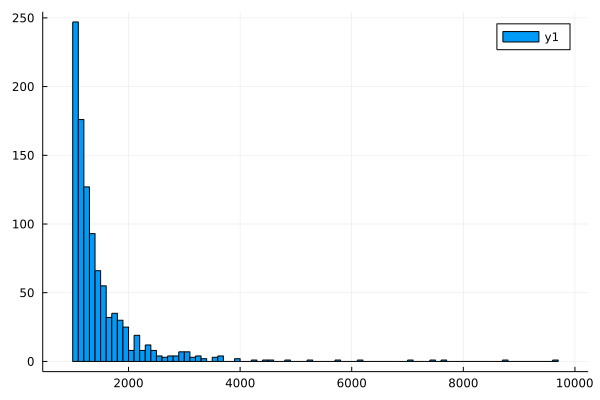

In [17]:
# representation of flow/runoff from randomised pareto distribution
α = 3
θ = 1000

Pareto(α, θ)
sample = rand(Pareto(α, θ), 1000)

histogram(sample)

### **Set up example network as tabular data and input parameters**

In [18]:
network = DataFrame(source = ["river1", "river2", "river3", "river4", "river5",
    "dam", "river6", "river7", "river8", "river9",
    "landslide", "landslide", "river8", "catchment1", "catchment2"], 
    target = ["river2", "river3", "river4", "river5",
    "dam", "river6", "river7", "river8", "river9", "river10",
    "river9", "infrastructure", "infrastructure", "river1", "river2"],
    type_source= ["river", "river", "river", "river", "river",
    "dam", "river", "river", "river", "river",
    "landslide", "landslide", "river", "catchment", "catchment"],
    magnitude = [1001.0, 1002.0, 1003.0, 1004.0, 1005.0, 1006.0, 1007.0, 1008.0, 1009.0, 1010.0, 0.0, 0.0, 1009.0, 0.0, 0.0])

,source,target,type_source,magnitude
,String,String,String,Float64
1,river1,river2,river,1001.0
2,river2,river3,river,1002.0
3,river3,river4,river,1003.0
4,river4,river5,river,1004.0
5,river5,dam,river,1005.0
6,dam,river6,dam,1006.0
7,river6,river7,river,1007.0
8,river7,river8,river,1008.0
9,river8,river9,river,1009.0


In [19]:
# set up input parameters
clock = []
present = []
record = []
global_time = 0

push!(clock, network)
@. network.time = global_time
past = clock[end]

,source,target,type_source,magnitude,time
,String,String,String,Float64,Int64
1,river1,river2,river,1001.0,0
2,river2,river3,river,1002.0,0
3,river3,river4,river,1003.0,0
4,river4,river5,river,1004.0,0
5,river5,dam,river,1005.0,0
6,dam,river6,dam,1006.0,0
7,river6,river7,river,1007.0,0
8,river7,river8,river,1008.0,0
9,river8,river9,river,1009.0,0


### **Example algorithm by node types during global time = 0**

In [20]:
# RIVERS & DAMS
df = filter([:type_source] => (x) -> x=="river" || x=="dam", past)
# past_df = filter([:type_source] => (x) -> x=="river", past)
df = innerjoin(df[:, Not([:magnitude, :time])], 
               df[:, [:target, :magnitude, :time]], 
               on=:source=>:target)
@. df.time += 1
push!(present, df)

1-element Vector{Any}:
 10×5 DataFrame
 Row │ source  target          type_source  magnitude  time  
     │ String  String          String       Float64    Int64 
─────┼───────────────────────────────────────────────────────
   1 │ river2  river3          river           1001.0      1
   2 │ river3  river4          river           1002.0      1
   3 │ river4  river5          river           1003.0      1
   4 │ river5  dam             river           1004.0      1
   5 │ dam     river6          dam             1005.0      1
   6 │ river6  river7          river           1006.0      1
   7 │ river7  river8          river           1007.0      1
   8 │ river8  river9          river           1008.0      1
   9 │ river8  infrastructure  river           1008.0      1
  10 │ river9  river10         river           1009.0      1

In [21]:
# LANDSLIDES
df = filter([:type_source] => (x) -> x=="landslide", past)
@. df.time += 1
# generate new landslide if time has come else wait (assume pareto probability distribution ... which is wrong and to be defined at later stage)
@. df.magnitude = ifelse(df.time > global_time, rand(Pareto(3, 1000)), df.magnitude)
# reset delay to 3 time units if time has come for a reset
@. df.time = ifelse(df.time > global_time, global_time + 3, df.time)
push!(present, df)

2-element Vector{Any}:
 10×5 DataFrame
 Row │ source  target          type_source  magnitude  time  
     │ String  String          String       Float64    Int64 
─────┼───────────────────────────────────────────────────────
   1 │ river2  river3          river           1001.0      1
   2 │ river3  river4          river           1002.0      1
   3 │ river4  river5          river           1003.0      1
   4 │ river5  dam             river           1004.0      1
   5 │ dam     river6          dam             1005.0      1
   6 │ river6  river7          river           1006.0      1
   7 │ river7  river8          river           1007.0      1
   8 │ river8  river9          river           1008.0      1
   9 │ river8  infrastructure  river           1008.0      1
  10 │ river9  river10         river           1009.0      1
 2×5 DataFrame
 Row │ source     target          type_source  magnitude  time  
     │ String     String          String       Float64    Int64 
─────┼──────────────

In [22]:
# CATCHMENTS
# current catchment to river if time has come otherwise wait
df = filter([:type_source] => (x) -> x=="catchment", past)
@. df.time += 1
@. df.magnitude = ifelse(df.time > global_time, rand(Pareto(3, 1000)), df.magnitude)
@. df.time = ifelse(df.time > global_time, global_time + 5, df.time)
push!(present, df)

# deal with the impact of catchment on rivers by cascading the runoff magnitude to rivers if time has come
df = filter([:source] => (x) -> x in Set(present[end].target), past)
# simulate all possible configurations of catchment/river
df = outerjoin(df, 
               present[end], # catchment behavior
               on=:source=>:target, 
               makeunique=true)
# if time has come (time > global time), catchment runoff to river ELSE 100 (base line value), 
@. df.magnitude = ifelse(global_time > df.time_1, # due
                    df.magnitude_1, 
                    100) # could be updated to match other nodes
@. df.time += 1
push!(present, df[:, [:source, :target, :type_source, :magnitude, :time]])

4-element Vector{Any}:
 10×5 DataFrame
 Row │ source  target          type_source  magnitude  time  
     │ String  String          String       Float64    Int64 
─────┼───────────────────────────────────────────────────────
   1 │ river2  river3          river           1001.0      1
   2 │ river3  river4          river           1002.0      1
   3 │ river4  river5          river           1003.0      1
   4 │ river5  dam             river           1004.0      1
   5 │ dam     river6          dam             1005.0      1
   6 │ river6  river7          river           1006.0      1
   7 │ river7  river8          river           1007.0      1
   8 │ river8  river9          river           1008.0      1
   9 │ river8  infrastructure  river           1008.0      1
  10 │ river9  river10         river           1009.0      1
 2×5 DataFrame
 Row │ source     target          type_source  magnitude  time  
     │ String     String          String       Float64    Int64 
─────┼──────────────

In [23]:
# CONCATENATE PRESENT NETWORK STATE
cat = reduce(vcat, present)

present = @chain cat begin
    groupby([:source, :target, :type_source])
    combine(:magnitude => sum => :magnitude)
  end

present = innerjoin(present, 
                    cat[:, [:source, :target, :time]], 
                    on=[:source, :target])

push!(record, present)

1-element Vector{Any}:
 16×5 DataFrame
 Row │ source      target          type_source  magnitude  time   
     │ String      String?         String?      Float64    Int64? 
─────┼────────────────────────────────────────────────────────────
   1 │ river2      river3          river          1101.0        1
   2 │ river3      river4          river          1002.0        1
   3 │ river4      river5          river          1003.0        1
   4 │ river5      dam             river          1004.0        1
   5 │ dam         river6          dam            1005.0        1
   6 │ river6      river7          river          1006.0        1
   7 │ river7      river8          river          1007.0        1
   8 │ river8      river9          river          1008.0        1
   9 │ river8      infrastructure  river          1008.0        1
  10 │ river9      river10         river          1009.0        1
  11 │ landslide   river9          landslide      1624.43       3
  12 │ landslide   infrastructure 

### **Create functions**

### **Add to time algorithm**

In [25]:
network = DataFrame(source = ["river1", "river2", "river3", "river4", "river5",
    "dam", "river6", "river7", "river8", "river9",
    "landslide", "landslide", "river8", "catchment1", "catchment2"], 
    target = ["river2", "river3", "river4", "river5",
    "dam", "river6", "river7", "river8", "river9", "river10",
    "river9", "infrastructure", "infrastructure", "river1", "river2"],
    type_source= ["river", "river", "river", "river", "river",
    "dam", "river", "river", "river", "river",
    "landslide", "landslide", "river", "catchment", "catchment"],
    magnitude = [1001.0, 1002.0, 1003.0, 1004.0, 1005.0, 1006.0, 1007.0, 1008.0, 1009.0, 1010.0, 0.0, 0.0, 1009.0, 0.0, 0.0])


,source,target,type_source,magnitude
,String,String,String,Float64
1,river1,river2,river,1001.0
2,river2,river3,river,1002.0
3,river3,river4,river,1003.0
4,river4,river5,river,1004.0
5,river5,dam,river,1005.0
6,dam,river6,dam,1006.0
7,river6,river7,river,1007.0
8,river7,river8,river,1008.0
9,river8,river9,river,1009.0


In [27]:
# set up input parameters
global_time = 0
@. network.time = global_time
clock = []
push!(clock, network)

for global_time in 1:10

    present = []
    past = clock[end]
    
    # RIVERS & DAMS #########################################################################
    df = filter([:type_source] => (x) -> x=="river" || x=="dam", past)
    # past_df = filter([:type_source] => (x) -> x=="river", past)
    df = innerjoin(df[:, Not([:magnitude, :time])], 
                df[:, [:target, :magnitude, :time]], 
                on=:source=>:target)
    @. df.time += 1
    push!(present, df)

    
    # LANDSLIDES ###########################################################################
    df = filter([:type_source] => (x) -> x=="landslide", past)
    @. df.time += 1
    # generate new landslide if time has come else wait (assume pareto probability distribution ... which is wrong and to be defined at later stage)
    @. df.magnitude = ifelse(df.time > global_time, rand(Pareto(3, 1000)), df.magnitude)
    # reset delay to 3 time units if time has come for a reset
    @. df.time = ifelse(df.time > global_time, global_time + 3, df.time)
    push!(present, df)


    # CATCHMENTS ##########################################################################
    # current catchment to river if time has come otherwise wait
    df = filter([:type_source] => (x) -> x=="catchment", past)
    @. df.time += 1
    @. df.magnitude = ifelse(df.time > global_time, rand(Pareto(3, 1000)), df.magnitude)
    @. df.time = ifelse(df.time > global_time, global_time + 5, df.time)
    push!(present, df)

    # deal with the impact of catchment on rivers by cascading the runoff magnitude to rivers if time has come
    df = filter([:source] => (x) -> x in Set(present[end].target), past)
    # simulate all possible configurations of catchment/river
    df = outerjoin(df, 
                present[end], # catchment behavior
                on=:source=>:target, 
                makeunique=true)
    # if time has come (time > global time), catchment runoff to river ELSE 100 (base line value), 
    @. df.magnitude = ifelse(global_time > df.time_1, # due
                        df.magnitude_1, 
                        100) # could be updated to match other nodes
    @. df.time += 1
    push!(present, df[:, [:source, :target, :type_source, :magnitude, :time]])


    # CONCATENATE PRESENT NETWORK STATE #####################################################
    # cat = reduce(vcat, present)

    present = @chain present begin
        reduce(vcat, _)
        groupby([:source, :target, :type_source: :time])
        combine(:magnitude => sum => :magnitude)
    end

    # present = innerjoin(present, 
    #                     cat[:, [:source, :target, :time]], 
    #                     on=[:source, :target])

    push!(clock, present)
    println("global_time : $global_time")
end

LoadError: MethodError: no method matching -(::Symbol, ::Symbol)
[0mClosest candidates are:
[0m  -([91m::ChainRulesCore.AbstractThunk[39m, ::Any) at ~/.julia/packages/ChainRulesCore/ksvfu/src/tangent_types/thunks.jl:32
[0m  -([91m::ChainRulesCore.ZeroTangent[39m, ::Any) at ~/.julia/packages/ChainRulesCore/ksvfu/src/tangent_arithmetic.jl:101
[0m  -([91m::ChainRulesCore.NotImplemented[39m, ::Any) at ~/.julia/packages/ChainRulesCore/ksvfu/src/tangent_arithmetic.jl:49
[0m  ...